In [83]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

In [84]:
DATA_FOLDER = "./cedas2025_material/data/"

In [85]:
df = pd.read_parquet(DATA_FOLDER + "chargecurves_train.parquet")

# Basic checks
df.info()
df.describe()
print("Columns:", df.columns.tolist())
print("Missing values:\n", df.isnull().sum())
print("Session IDs:", df['id'].nunique())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3960349 entries, 0 to 3960348
Data columns (total 7 columns):
 #   Column         Dtype         
---  ------         -----         
 0   id             int64         
 1   timestamp      datetime64[ns]
 2   soc            float64       
 3   power          float64       
 4   nominal_power  float64       
 5   location_id    int64         
 6   sub_id         int64         
dtypes: datetime64[ns](1), float64(3), int64(3)
memory usage: 211.5 MB
Columns: ['id', 'timestamp', 'soc', 'power', 'nominal_power', 'location_id', 'sub_id']
Missing values:
 id                  0
timestamp           0
soc              6081
power            7127
nominal_power       0
location_id         0
sub_id              0
dtype: int64
Session IDs: 99581


In [86]:
# Check power range
valid_power = df[(df['power'] >= 0) & (df['power'] <= 350)]  # Adjust
invalid_power = df[~df.index.isin(valid_power.index)]

# Check SOC validity
valid_soc = df[(df['soc'] >= 0) & (df['soc'] <= 100)]
invalid_soc = df[~df.index.isin(valid_soc.index)]

# check whether SOC increases within sessions
soc_increasing = df.groupby('id')['soc'].apply(lambda x: x.is_monotonic_increasing)
invalid_sessions = soc_increasing[~soc_increasing].index
df_clean = df[~df['id'].isin(invalid_sessions)]

print(df_clean)

             id           timestamp   soc  power  nominal_power  location_id  \
0             1 2023-03-15 09:46:44  42.0  37.73           62.5            0   
1             1 2023-03-15 09:47:44  44.0  30.10           62.5            0   
2             1 2023-03-15 09:48:44  46.0  27.46           62.5            0   
3             1 2023-03-15 09:49:44  49.0  26.42           62.5            0   
4             1 2023-03-15 09:50:44  51.0  25.46           62.5            0   
...         ...                 ...   ...    ...            ...          ...   
3960344  140000 2023-08-06 05:16:44  75.0  28.19           50.0            6   
3960345  140000 2023-08-06 05:17:44  76.0  28.65           50.0            6   
3960346  140000 2023-08-06 05:18:44  76.0  28.80           50.0            6   
3960347  140000 2023-08-06 05:19:44  77.0  28.95           50.0            6   
3960348  140000 2023-08-06 05:20:44  78.0  28.42           50.0            6   

         sub_id  
0             0  
1  

/var/folders/2k/ybmt4k493c9_s0p74bsbpb700000gn/T/ipykernel_31106/1072621953.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['soc_bin'] = pd.cut(df_clean['soc'], bins=np.arange(0, 105, 5))
/var/folders/2k/ybmt4k493c9_s0p74bsbpb700000gn/T/ipykernel_31106/1072621953.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  avg_by_soc = df_clean.groupby('soc_bin')['power'].mean()


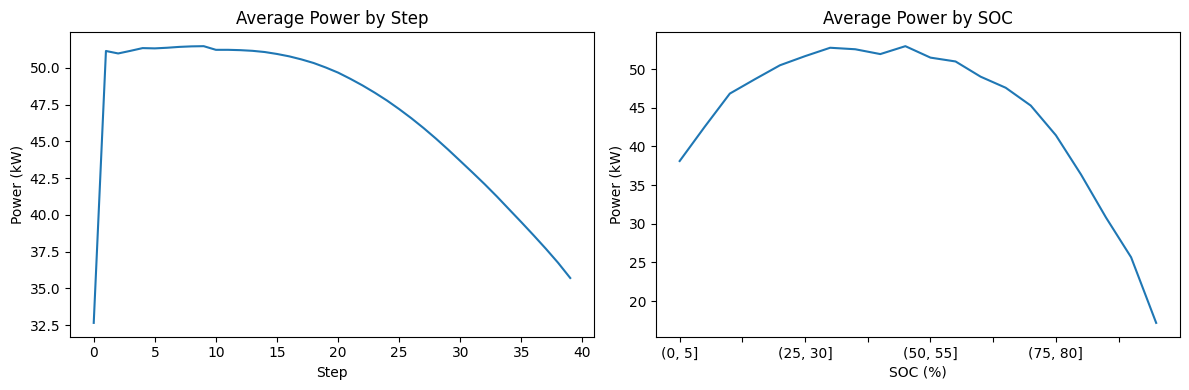

In [87]:
# By step
avg_by_step = df_clean.groupby('sub_id')['power'].mean()

# By SOC (bin into 5% intervals)
df_clean['soc_bin'] = pd.cut(df_clean['soc'], bins=np.arange(0, 105, 5))
avg_by_soc = df_clean.groupby('soc_bin')['power'].mean()

# Plot
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
avg_by_step.plot(ax=ax[0], title='Average Power by Step', xlabel='Step', ylabel='Power (kW)')
avg_by_soc.plot(ax=ax[1], title='Average Power by SOC', xlabel='SOC (%)', ylabel='Power (kW)')
plt.tight_layout()
plt.show()

/var/folders/2k/ybmt4k493c9_s0p74bsbpb700000gn/T/ipykernel_31106/421999878.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['timestamp'] = pd.to_datetime(df_clean['timestamp'])
/var/folders/2k/ybmt4k493c9_s0p74bsbpb700000gn/T/ipykernel_31106/421999878.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['hour'] = df_clean['timestamp'].dt.hour
/var/folders/2k/ybmt4k493c9_s0p74bsbpb700000gn/T/ipykernel_31106/421999878.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of 

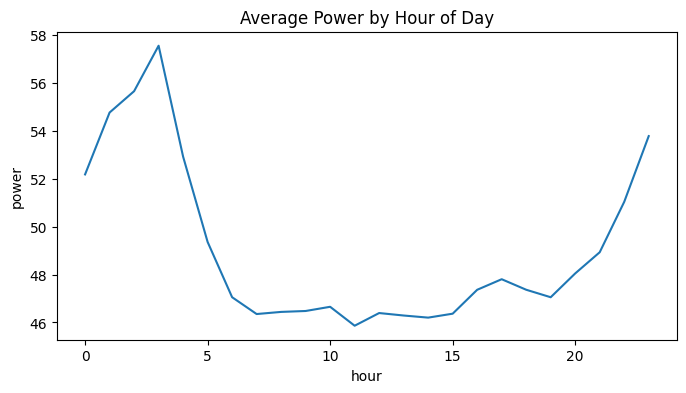

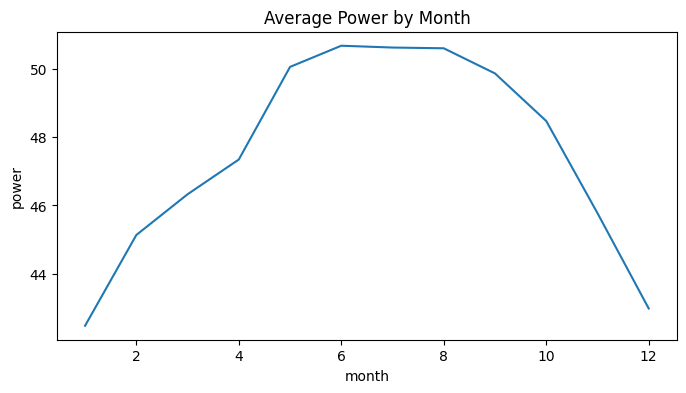

In [88]:
df_clean['timestamp'] = pd.to_datetime(df_clean['timestamp'])
df_clean['hour'] = df_clean['timestamp'].dt.hour
df_clean['weekday'] = df_clean['timestamp'].dt.weekday
df_clean['month'] = df_clean['timestamp'].dt.month

# Average power by hour
plt.figure(figsize=(8, 4))
sns.lineplot(data=df_clean, x='hour', y='power', errorbar=None)
plt.title('Average Power by Hour of Day')
plt.show()

# Monthly trends
plt.figure(figsize=(8, 4))
sns.lineplot(data=df_clean, x='month', y='power', errorbar=None)
plt.title('Average Power by Month')
plt.show()

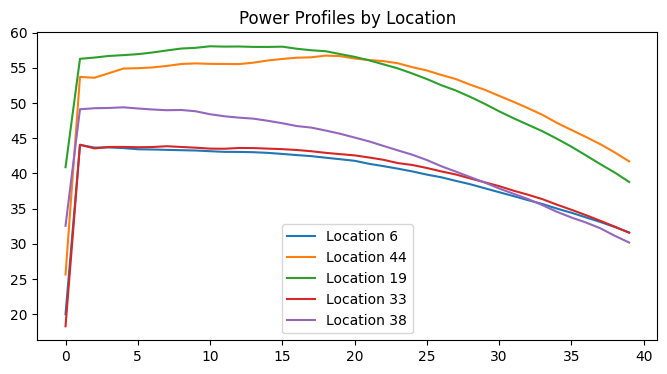

In [89]:
# Top locations
top_locs = df_clean['location_id'].value_counts().nlargest(5).index

# Plot average curves for top locations
plt.figure(figsize=(8, 4))
for loc in top_locs:
    loc_data = df_clean[df_clean['location_id'] == loc]
    loc_avg = loc_data.groupby('sub_id')['power'].mean()
    plt.plot(loc_avg, label=f'Location {loc}')
plt.legend()
plt.title('Power Profiles by Location')
plt.show()

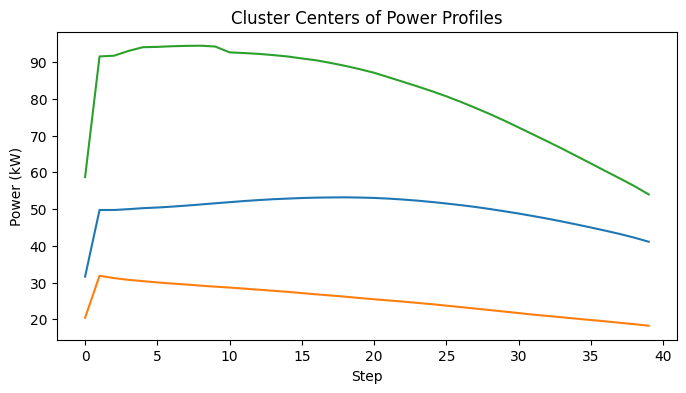

In [90]:
# Pivot to session-step matrix
pivot_df = df_clean.pivot(index='id', columns='sub_id', values='power').fillna(0)

# Standardize and cluster
scaler = StandardScaler()
scaled_data = scaler.fit_transform(pivot_df)
kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(scaled_data)

# Plot cluster centers
centers = scaler.inverse_transform(kmeans.cluster_centers_)
plt.figure(figsize=(8, 4))
for center in centers:
    plt.plot(center)
plt.title('Cluster Centers of Power Profiles')
plt.xlabel('Step')
plt.ylabel('Power (kW)')
plt.show()

- Remove/impute outliers

- Exclude sessions with invalid SOC progression.

- Investigate if errors correlate with specific locations or times.

In [91]:
# Flag records with out-of-range power and SOC, create Boolean flags for each type of error
df['error_power'] = ~((df['power'] >= 0) & (df['power'] <= 350))
df['error_soc'] = ~((df['soc'] >= 0) & (df['soc'] <= 100))

# Check whether SOC increases within sessions
# (This produces a flag per session; we then assign the error flag to every record in that session)
soc_increasing = df.groupby('id')['soc'].apply(lambda x: x.is_monotonic_increasing)
invalid_sessions = soc_increasing[~soc_increasing].index
df['error_session'] = df['id'].isin(invalid_sessions)


- error_power is True when a reading’s power is outside the range [0, 350].
- error_soc is True when SOC is not between 0 and 100.
- error_session is True for every record belonging to a session that has a non-monotonic SOC (i.e., a session flagged as having an error).

Convert Timestamps to Datetime and Extract Time Components

In [92]:
df['timestamp'] = pd.to_datetime(df['timestamp'])
df['hour'] = df['timestamp'].dt.hour
df['month'] = df['timestamp'].dt.month

In [93]:
# Sum up errors by location
errors_by_location = df.groupby('location_id')[['error_power', 'error_soc', 'error_session']].sum()
top20_errors = errors_by_location.sort_values(by='error_power', ascending=False).head(20)

print(errors_by_location)

             error_power  error_soc  error_session
location_id                                       
0                      0         14            320
1                      0         42            120
2                      4          4             66
3                      0          0            160
4                      0          0              0
...                  ...        ...            ...
329                    0          0              0
331                    0          0              0
339                    0          0              0
341                    0          0              0
345                    0          0              0

[306 rows x 3 columns]


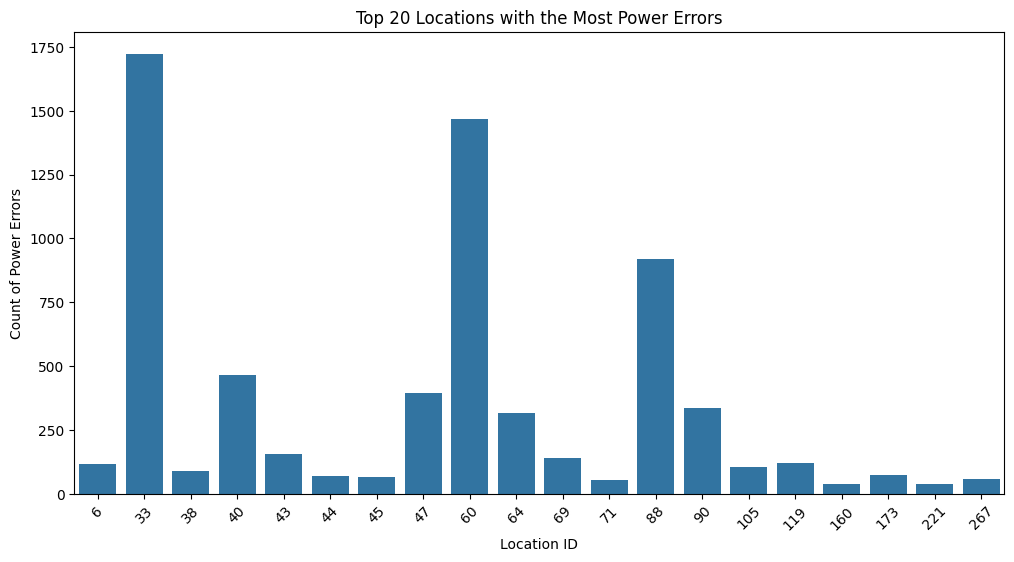

In [94]:
# Reset index to make 'location_id' a column
top20_errors = top20_errors.reset_index()

# Plot only the error_power column against location_id
plt.figure(figsize=(12, 6))
sns.barplot(data=top20_errors, x='location_id', y='error_power')
plt.title('Top 20 Locations with the Most Power Errors')
plt.xlabel('Location ID')
plt.ylabel('Count of Power Errors')
plt.xticks(rotation=45)
plt.show()

In [95]:
missing_values = df.isnull().sum()
print("Missing values in each column:")
print(missing_values)

Missing values in each column:
id                  0
timestamp           0
soc              6081
power            7127
nominal_power       0
location_id         0
sub_id              0
error_power         0
error_soc           0
error_session       0
hour                0
month               0
dtype: int64


In [96]:
df['power'] = df['power'].fillna(df['power'].median())
df['soc'] = df['soc'].fillna(df['soc'].median())

Define ranges for columns

In [97]:
df = df[(df['power'] >= 0) & (df['power'] <= 350)]
df = df[(df['soc'] >= 0) & (df['soc'] <= 100)]

def remove_outliers_IQR(data, column):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return data[(data[column] >= lower_bound) & (data[column] <= upper_bound)]

# Remove outliers in the 'power' column using IQR
df = remove_outliers_IQR(df, 'power')
df = remove_outliers_IQR(df, 'soc')

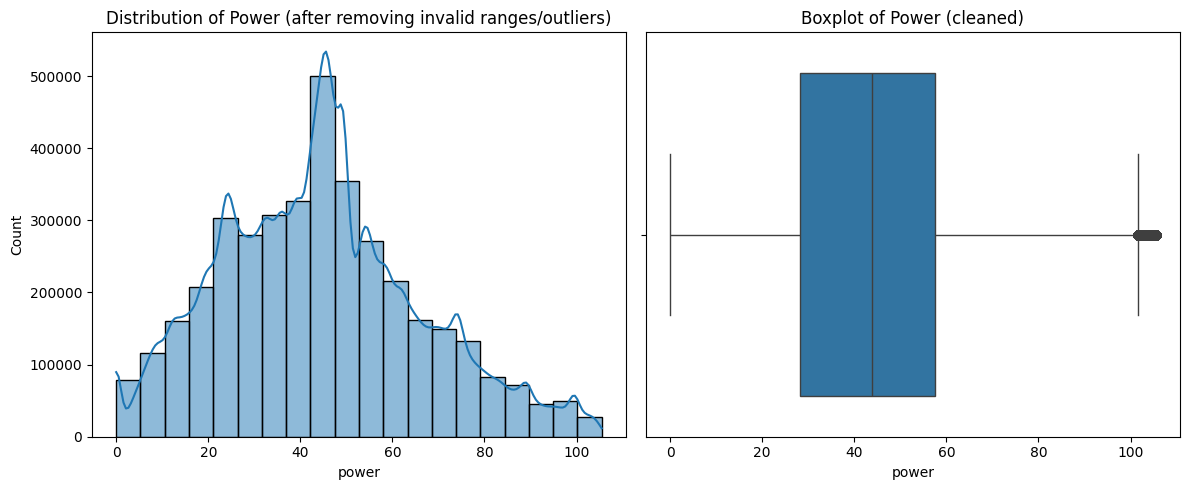

In [98]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.histplot(df['power'], bins=20, kde=True)
plt.title('Distribution of Power (after removing invalid ranges/outliers)')

plt.subplot(1, 2, 2)
sns.boxplot(x=df['power'])
plt.title('Boxplot of Power (cleaned)')
plt.tight_layout()
plt.show()